In [137]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, multilabel_confusion_matrix, precision_recall_curve, accuracy_score, f1_score

In [138]:
# Load the finalized dataset
df = pd.read_csv("../Datasets/pokedex_final.csv")

# Combine type1 and type2 into a list
df['type_list'] = df[['type1', 'type2']].values.tolist()
df['type_list'] = df['type_list'].apply(lambda x: [t for t in x if pd.notna(t) and t != ''])

# Encode the types with MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y_types = mlb.fit_transform(df['type_list'])  # type labels
y_is_dual = df['is_dual_type'].values # mono/dual labels

# Tokenize the enhanced_info column
text_tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
text_tokenizer.fit_on_texts(df['enhanced_info'])

sequences = text_tokenizer.texts_to_sequences(df['enhanced_info'])
X_text = pad_sequences(sequences, maxlen=300, padding='post', truncating='post')

# Normalize numeric features
stats_cols = ['hp', 'attack', 'defense', 's_attack', 'speed', 'height', 'weight']
scaler = StandardScaler()
X_stats = scaler.fit_transform(df[stats_cols])

In [139]:
# --- Create separate outputs for type1 and type2 ---
from sklearn.preprocessing import LabelBinarizer

# >>> Create is_dual_type if not already done (just in case)
df['is_dual_type'] = df['type2'].notna().astype(int)

# >>> Encode primary type
lb_type1 = LabelBinarizer()
y_type1 = lb_type1.fit_transform(df['type1'])

# >>> Fill missing secondary types with 'None' so LabelBinarizer doesn't fail
df['type2_filled'] = df['type2'].fillna('None')

# >>> Encode secondary type
lb_type2 = LabelBinarizer()
y_type2 = lb_type2.fit_transform(df['type2_filled'])

# >>> Already computed earlier
y_dual = df['is_dual_type'].values


In [140]:
# Text input
input_text = Input(shape=(300,), name='text_input')
text_embed = Embedding(input_dim=5000, output_dim=64, input_length=300)(input_text)

# Bidirectional LSTM
text_lstm = Bidirectional(LSTM(128, dropout=0.2))(text_embed)

# Stats input
input_stats = Input(shape=(X_stats.shape[1],), name='stats_input')

# Combine text and stats
combined = Concatenate()([text_lstm, input_stats])

# Hidden dense layer
hidden = Dense(256, activation='relu')(combined)
hidden = Dropout(0.5)(hidden)

# >>> Now split into three outputs:

# Output 1: Primary Type (multi-class)
type1_output = Dense(y_type1.shape[1], activation='softmax', name='type1_output')(hidden)

# Output 2: Secondary Type (multi-class including 'None')
type2_output = Dense(y_type2.shape[1], activation='softmax', name='type2_output')(hidden)

# Output 3: Mono/Dual classification (binary)
dual_output = Dense(1, activation='sigmoid', name='dual_output')(hidden)

# Build model
model = Model(inputs=[input_text, input_stats], outputs=[type1_output, type2_output, dual_output])

# Compile model with 3 losses
model.compile(
    optimizer='adam',
    loss={
        'type1_output': 'categorical_crossentropy',
        'type2_output': 'categorical_crossentropy',
        'dual_output': 'binary_crossentropy'
    },
    metrics={
        'type1_output': 'accuracy',
        'type2_output': 'accuracy',
        'dual_output': 'accuracy'
    }
)

model.summary()

# Calculate class weights based on label frequency
class_totals = y_types.sum(axis=0)  
class_weights = y_types.shape[0] / (len(mlb.classes_) * class_totals)

# Convert class weights to numpy array
class_weights = np.array(class_weights)

# Print class weights to check
print(dict(zip(mlb.classes_, class_weights)))

# Train-Test Split
X_train_text, X_test_text, \
X_train_stats, X_test_stats, \
y_train_type1, y_test_type1, \
y_train_type2, y_test_type2, \
y_train_dual, y_test_dual = train_test_split(
    X_text, X_stats, y_type1, y_type2, y_dual, test_size=0.2, random_state=42
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model
history = model.fit(
    [X_train_text, X_train_stats],
    {
        'type1_output': y_train_type1,
        'type2_output': y_train_type2,
        'dual_output': y_train_dual
    },
    validation_data=(
        [X_test_text, X_test_stats],
        {
            'type1_output': y_test_type1,
            'type2_output': y_test_type2,
            'dual_output': y_test_dual
        }
    ),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop]
)

# Updated thresholds based on your new dictionary
best_thresholds = np.array([
    0.0010278029,  # bug
    8.1377993e-07, # dark
    0.46437493,    # dragon
    0.0019469165,  # electric
    3.991257e-05,  # fairy
    0.00040400133, # fighting
    0.90612555,    # fire
    0.72205424,    # flying
    1.6753791e-05, # ghost
    0.0010286915,  # grass
    0.0018877859,  # ground
    0.0066630044,  # ice
    0.00015980248, # normal
    0.005488699,   # poison
    0.21398078,    # psychic
    0.0042396197,  # rock
    0.0007712165,  # steel
    0.08663599     # water
])


# Adjust the threshold for specific types based on their frequencies
fairy_idx = list(mlb.classes_).index('fairy')
best_thresholds[fairy_idx] = 0.5  # Lower threshold for fairy (to make it easier to predict)

ice_idx = list(mlb.classes_).index('ice')
best_thresholds[ice_idx] = 0.3  # Lower threshold for ice

ghost_idx = list(mlb.classes_).index('ghost')
best_thresholds[ghost_idx] = 0.3  # Lower threshold for ghost

steel_idx = list(mlb.classes_).index('steel')
best_thresholds[steel_idx] = 0.4  # Lower threshold for steel

dragon_idx = list(mlb.classes_).index('dragon')
best_thresholds[dragon_idx] = 0.4  # Lower threshold for dragon

dark_idx = list(mlb.classes_).index('dark')
best_thresholds[dark_idx] = 0.4  # Lower threshold for dark

electric_idx = list(mlb.classes_).index('electric')
best_thresholds[electric_idx] = 0.4  # Lower threshold for electric

# Save model and label binarizer
model.save("rnn_stats_pokemon_model.keras")
pd.DataFrame(mlb.classes_, columns=['Type']).to_csv("type_classes.csv", index=False)

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 300)]                0         []                            
                                                                                                  
 embedding_14 (Embedding)    (None, 300, 64)              320000    ['text_input[0][0]']          
                                                                                                  
 bidirectional_14 (Bidirect  (None, 256)                  197632    ['embedding_14[0][0]']        
 ional)                                                                                           
                                                                                                  
 stats_input (InputLayer)    [(None, 7)]                  0         []                     

In [141]:
# Load model
model = tf.keras.models.load_model("rnn_stats_pokemon_model.keras")

# Predict probabilities
y_pred_type1_probs, y_pred_type2_probs, y_pred_dual_probs = model.predict([X_test_text, X_test_stats])

# >>> Find best threshold for type1 only
best_thresholds = []

for i in range(y_test_type1.shape[1]):
    precision, recall, thresholds = precision_recall_curve(y_test_type1[:, i], y_pred_type1_probs[:, i])
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_threshold = thresholds[np.argmax(f1)]
    best_thresholds.append(best_threshold)

best_thresholds = np.array(best_thresholds)

# Apply best thresholds to type1 predictions
y_pred_type1 = (y_pred_type1_probs > best_thresholds).astype(int)


7/7 [==============================] - 0s 33ms/step


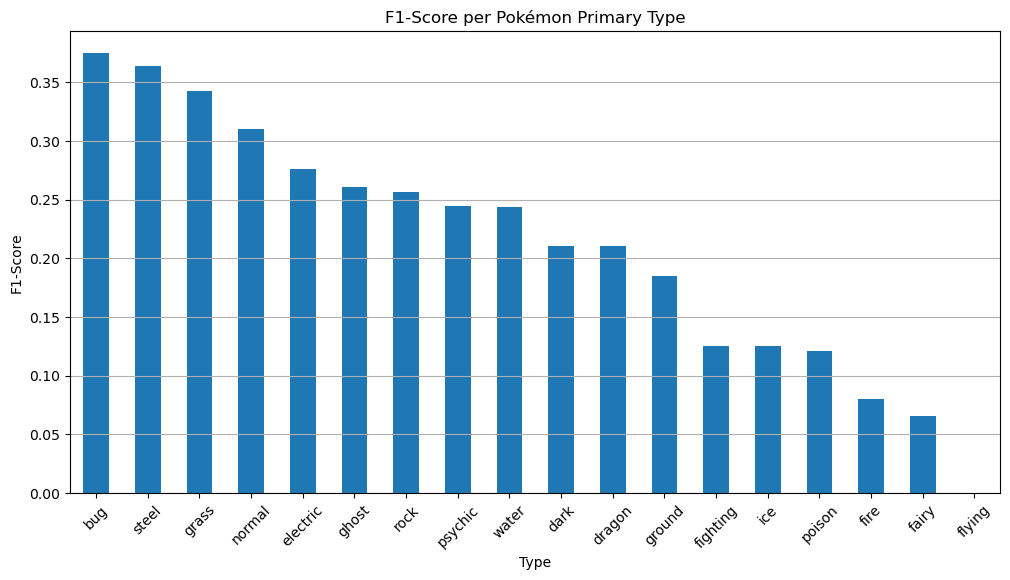

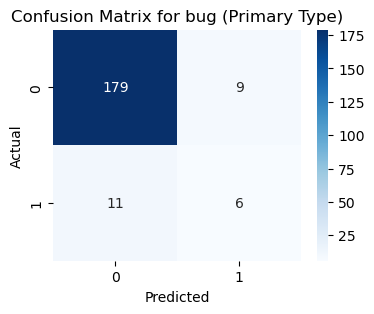

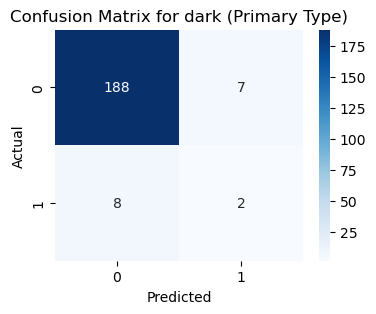

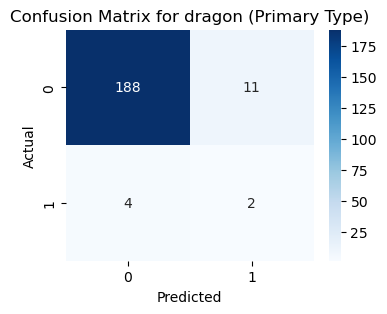

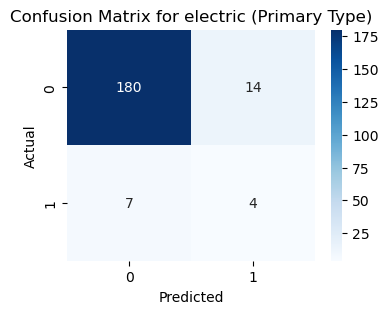

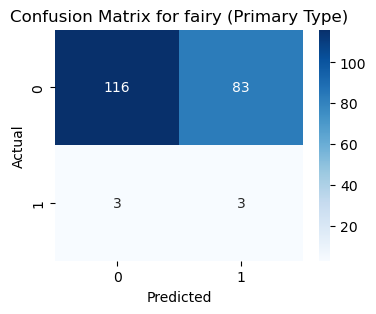

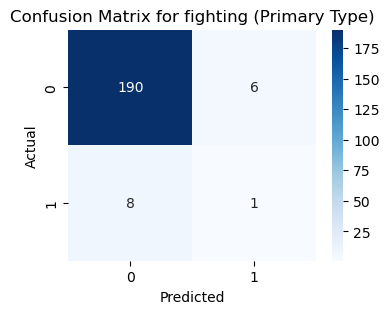

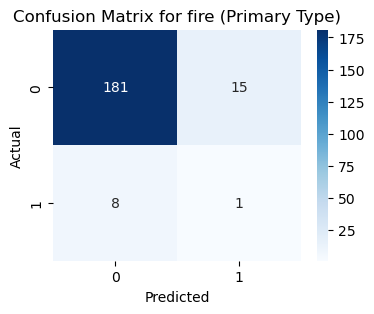

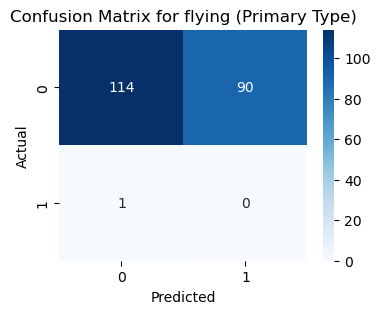

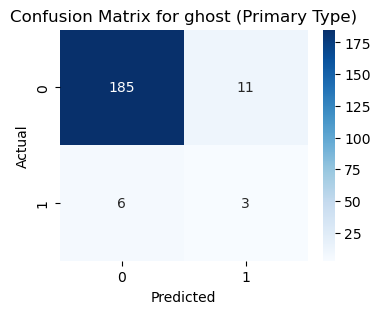

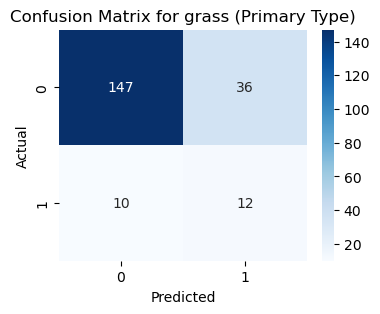

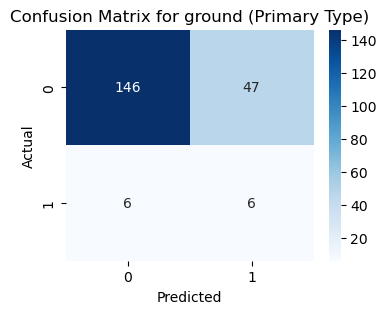

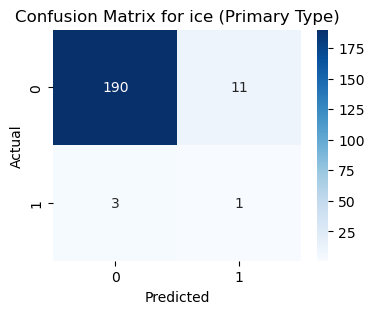

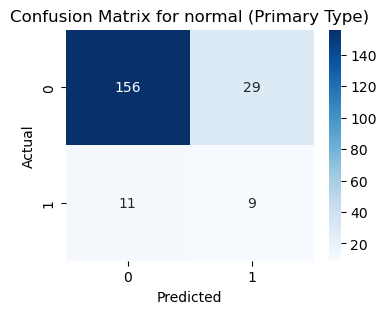

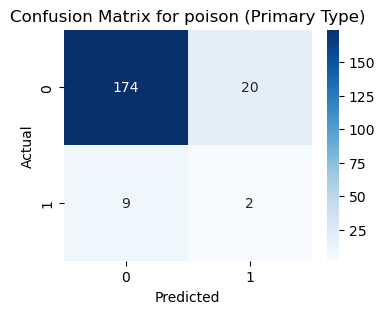

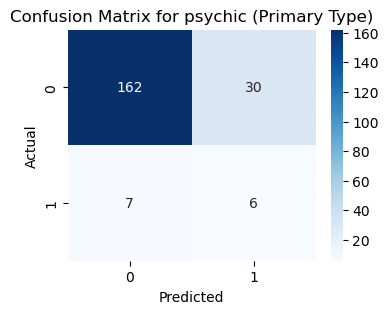

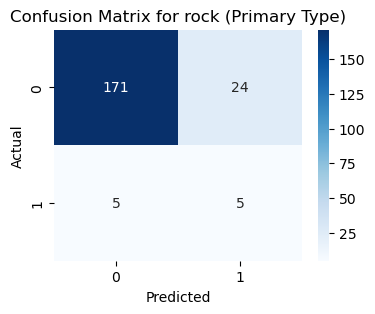

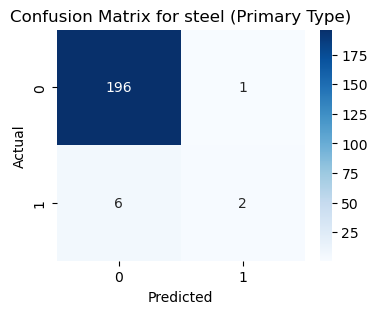

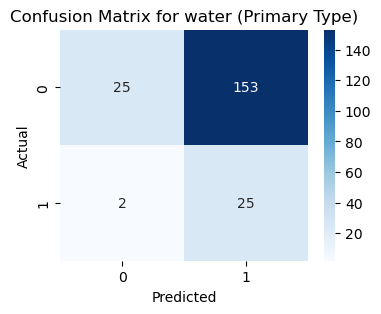

In [142]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# >>> Classification report for primary type (type1)
report = classification_report(y_test_type1, y_pred_type1, target_names=lb_type1.classes_, output_dict=True)

# Convert to DataFrame
report_df = pd.DataFrame(report).transpose()

# Display F1 scores per type1
f1_scores = report_df.loc[lb_type1.classes_, 'f1-score']
plt.figure(figsize=(12,6))
f1_scores.sort_values(ascending=False).plot(kind='bar')
plt.title('F1-Score per Pokémon Primary Type')
plt.ylabel('F1-Score')
plt.xlabel('Type')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# >>> Confusion matrices for primary type
conf_matrices = multilabel_confusion_matrix(y_test_type1, y_pred_type1)

for idx, type_name in enumerate(lb_type1.classes_[:18]):  # first 18 types only
    cm = conf_matrices[idx]
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {type_name} (Primary Type)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


/opt/miniconda3/envs/datascience/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


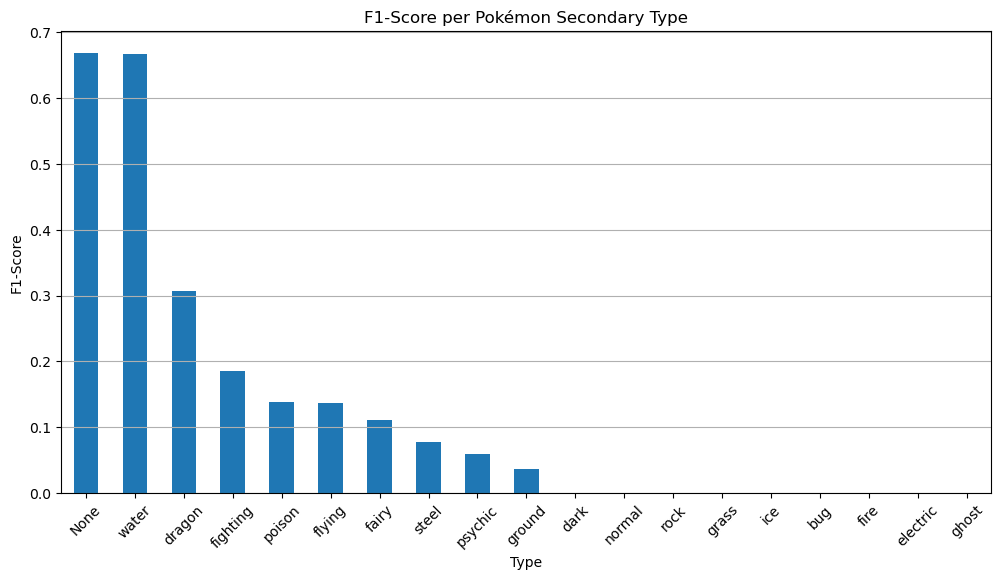

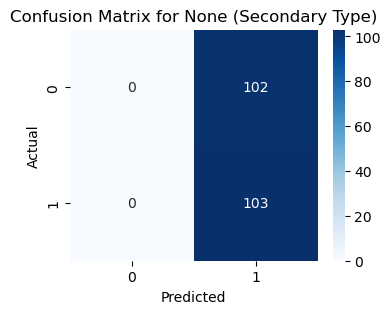

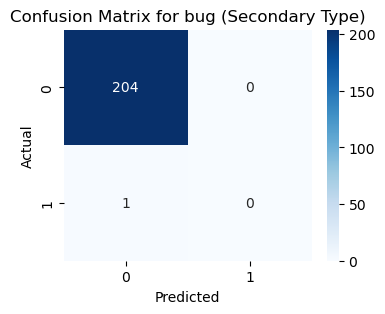

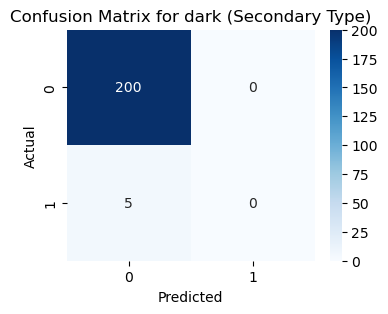

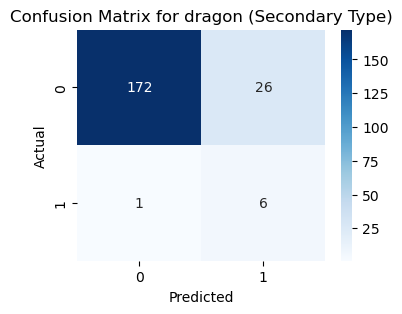

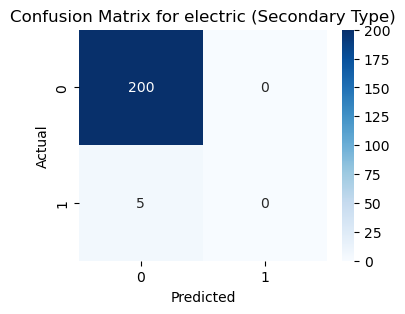

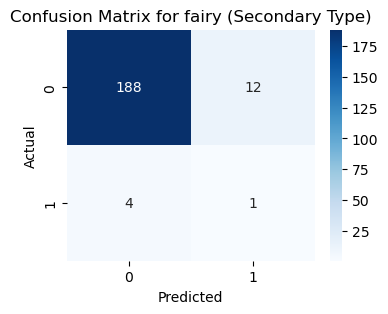

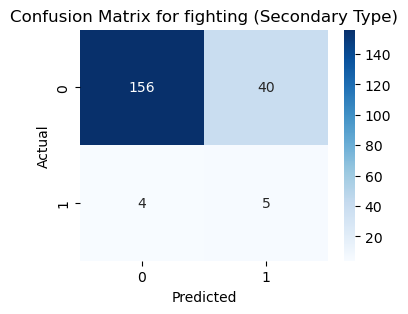

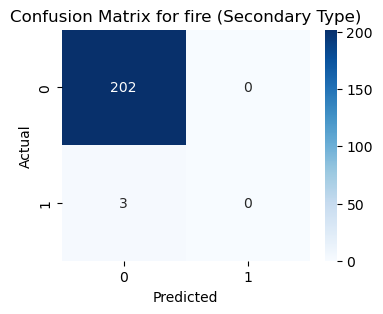

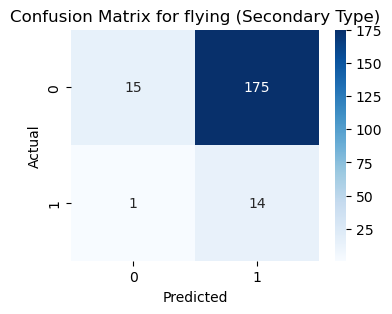

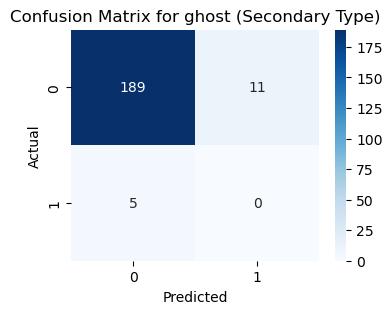

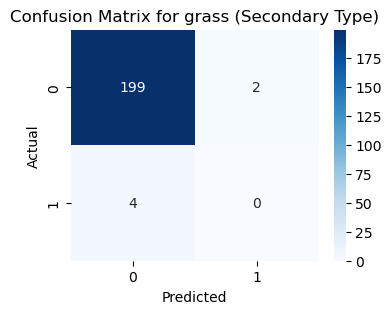

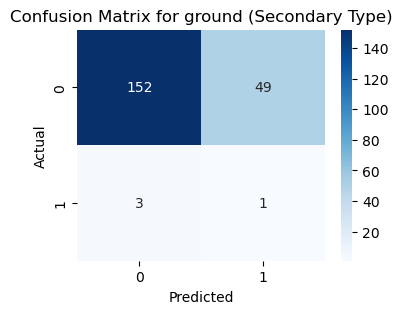

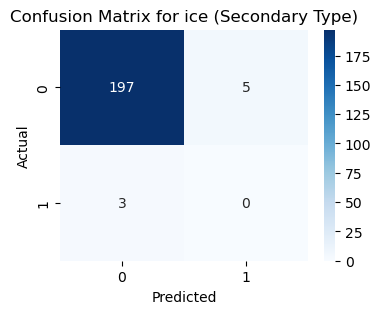

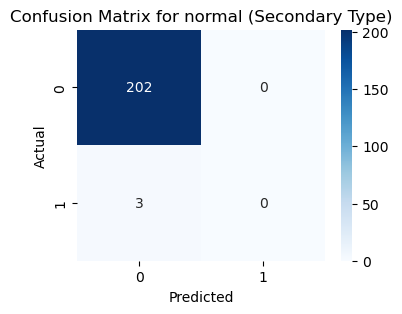

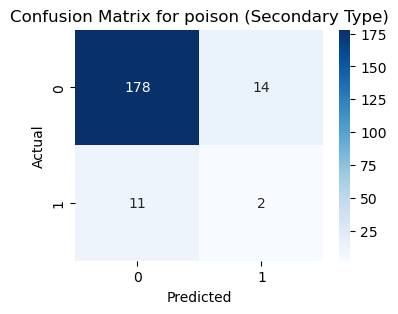

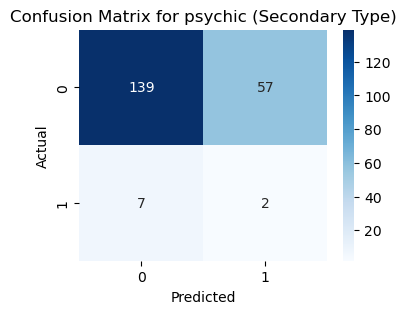

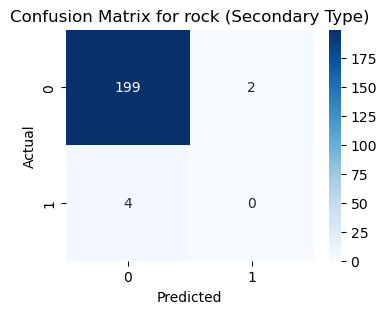

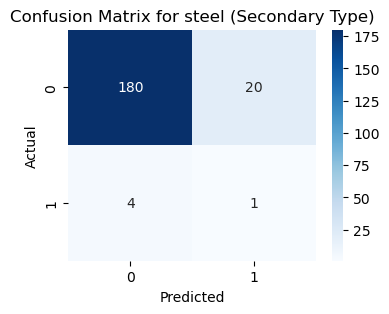

In [143]:
# >>> Threshold the secondary type probabilities to get final binary predictions
y_pred_type2 = (y_pred_type2_probs > 0.05).astype(int)  # or use custom thresholds if you calculated them

# >>> Classification report for secondary type (type2)
report_type2 = classification_report(y_test_type2, y_pred_type2, target_names=lb_type2.classes_, output_dict=True)

# Convert to DataFrame
report_df_type2 = pd.DataFrame(report_type2).transpose()

# Display F1 scores per type2
f1_scores_type2 = report_df_type2.loc[lb_type2.classes_, 'f1-score']
plt.figure(figsize=(12,6))
f1_scores_type2.sort_values(ascending=False).plot(kind='bar')
plt.title('F1-Score per Pokémon Secondary Type')
plt.ylabel('F1-Score')
plt.xlabel('Type')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# >>> Confusion matrices for secondary type
conf_matrices_type2 = multilabel_confusion_matrix(y_test_type2, y_pred_type2)

for idx, type_name in enumerate(lb_type2.classes_[:18]):  # first 18 types only
    cm = conf_matrices_type2[idx]
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {type_name} (Secondary Type)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [144]:
from sklearn.metrics import classification_report, precision_recall_curve
import numpy as np
import pandas as pd

# >>> Determine best threshold for each secondary type class
best_thresholds_type2 = []

for i in range(y_test_type2.shape[1]):
    precision, recall, thresholds = precision_recall_curve(y_test_type2[:, i], y_pred_type2_probs[:, i])
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_threshold = thresholds[np.argmax(f1)]
    best_thresholds_type2.append(best_threshold)

best_thresholds_type2 = np.array(best_thresholds_type2)

# >>> Apply thresholds
y_pred_type2 = (y_pred_type2_probs > best_thresholds_type2).astype(int)

# >>> Classification report for secondary type predictions
report_type2 = classification_report(
    y_test_type2, 
    y_pred_type2, 
    target_names=lb_type2.classes_, 
    output_dict=True
)

# >>> Convert to DataFrame for readability
report_df_type2 = pd.DataFrame(report_type2).transpose()

# >>> Print F1 scores per type
print("F1 Scores for Secondary Type (type2_output):")
print(report_df_type2['f1-score'])

# >>> Print average F1 scores
print("\nAverage F1 Scores:")
print(f"Macro Avg: {report_df_type2.loc['macro avg', 'f1-score']:.4f}")
print(f"Weighted Avg: {report_df_type2.loc['weighted avg', 'f1-score']:.4f}")

F1 Scores for Secondary Type (type2_output):
None            0.704545
bug             0.000000
dark            0.000000
dragon          0.400000
electric        0.000000
fairy           0.100000
fighting        0.235294
fire            0.028571
flying          0.296296
ghost           0.056338
grass           0.000000
ground          0.000000
ice             0.054054
normal          0.038462
poison          0.148148
psychic         0.000000
rock            0.000000
steel           0.129032
water           0.000000
micro avg       0.273684
macro avg       0.115302
weighted avg    0.417787
samples avg     0.393298
Name: f1-score, dtype: float64

Average F1 Scores:
Macro Avg: 0.1153
Weighted Avg: 0.4178


/opt/miniconda3/envs/datascience/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [145]:
y_pred_type1_probs, y_pred_type2_probs, y_pred_dual_probs = model.predict([X_test_text, X_test_stats])

print("Max type1 prob:", np.max(y_pred_type1_probs))
print("Mean type1 prob:", np.mean(y_pred_type1_probs))

print("Max type2 prob:", np.max(y_pred_type2_probs))
print("Mean type2 prob:", np.mean(y_pred_type2_probs))

print("Max dual prob:", np.max(y_pred_dual_probs))
print("Mean dual prob:", np.mean(y_pred_dual_probs))


7/7 [==============================] - 0s 42ms/step
Max type1 prob: 0.6762017
Mean type1 prob: 0.055555556
Max type2 prob: 0.9263988
Mean type2 prob: 0.05263158
Max dual prob: 0.83399755
Mean dual prob: 0.50705016


In [146]:
import numpy as np

# Sum predictions and true labels for PRIMARY TYPE
pred_counts = y_pred_type1.sum(axis=0)
true_counts = y_test_type1.sum(axis=0)

# Print for each primary type
for cls, pred, true in zip(lb_type1.classes_, pred_counts, true_counts):
    print(f"{cls:10s} | predicted: {int(pred):3d} | actual: {int(true):3d}")



bug        | predicted:  15 | actual:  17
dark       | predicted:   9 | actual:  10
dragon     | predicted:  13 | actual:   6
electric   | predicted:  18 | actual:  11
fairy      | predicted:  86 | actual:   6
fighting   | predicted:   7 | actual:   9
fire       | predicted:  16 | actual:   9
flying     | predicted:  90 | actual:   1
ghost      | predicted:  14 | actual:   9
grass      | predicted:  48 | actual:  22
ground     | predicted:  53 | actual:  12
ice        | predicted:  12 | actual:   4
normal     | predicted:  38 | actual:  20
poison     | predicted:  22 | actual:  11
psychic    | predicted:  36 | actual:  13
rock       | predicted:  29 | actual:  10
steel      | predicted:   3 | actual:   8
water      | predicted: 178 | actual:  27


In [147]:
# Sum predictions and true labels for SECONDARY TYPE
pred_counts_type2 = y_pred_type2.sum(axis=0)
true_counts_type2 = y_test_type2.sum(axis=0)

for cls, pred, true in zip(lb_type2.classes_, pred_counts_type2, true_counts_type2):
    print(f"{cls:10s} | predicted: {int(pred):3d} | actual: {int(true):3d}")

None       | predicted: 161 | actual: 103
bug        | predicted:  77 | actual:   1
dark       | predicted:   2 | actual:   5
dragon     | predicted:   3 | actual:   7
electric   | predicted:  28 | actual:   5
fairy      | predicted:  15 | actual:   5
fighting   | predicted:  25 | actual:   9
fire       | predicted:  67 | actual:   3
flying     | predicted:  12 | actual:  15
ghost      | predicted:  66 | actual:   5
grass      | predicted:   3 | actual:   4
ground     | predicted:   7 | actual:   4
ice        | predicted:  34 | actual:   3
normal     | predicted:  49 | actual:   3
poison     | predicted:  41 | actual:  13
psychic    | predicted:   0 | actual:   9
rock       | predicted:   3 | actual:   4
steel      | predicted:  57 | actual:   5
water      | predicted:   0 | actual:   2


In [148]:
import pandas as pd

df['type_list'] = df[['type1', 'type2']].values.tolist()
df['type_list'] = df['type_list'].apply(lambda x: [t for t in x if pd.notna(t)])

all_types = pd.Series([t for sublist in df['type_list'] for t in sublist])
print(all_types.value_counts())


water       154
normal      131
grass       127
flying      109
psychic     102
bug          92
poison       83
fire         81
ground       75
rock         74
fighting     73
dragon       70
dark         69
electric     69
steel        65
ghost        65
fairy        64
ice          48
Name: count, dtype: int64


In [149]:
print(dict(zip(mlb.classes_, best_thresholds)))

{'bug': 0.13473687, 'dark': 0.06262118, 'dragon': 0.057954684, 'electric': 0.09946601, 'fairy': 0.027069129, 'fighting': 0.0750932, 'fire': 0.09378366, 'flying': 0.010075141, 'ghost': 0.049091164, 'grass': 0.10989202, 'ground': 0.03763168, 'ice': 0.048006486, 'normal': 0.16908325, 'poison': 0.04610271, 'psychic': 0.07336528, 'rock': 0.090496905, 'steel': 0.1247478, 'water': 0.10788353}


In [150]:
from sklearn.metrics import classification_report, precision_recall_curve
import pandas as pd
import numpy as np

# Classification report for primary type (type1_output)
report = classification_report(y_test_type1, y_pred_type1, target_names=lb_type1.classes_, output_dict=True)

# Convert the classification report into a DataFrame for better readability
report_df = pd.DataFrame(report).transpose()

# Extract the F1 scores for each type (both per-class and averages)
f1_scores_per_type = report_df['f1-score']

# Print F1 scores for each class
print("F1 Scores for Primary Pokémon Type:")
print(f1_scores_per_type)

# Print the average F1 scores
print("\nAverage F1 Scores:")
print(f"Macro Average F1: {report_df.loc['macro avg', 'f1-score']:.4f}")
print(f"Weighted Average F1: {report_df.loc['weighted avg', 'f1-score']:.4f}")

# --- Top-2 Accuracy Calculation ---
# (Finding the two highest type1 probabilities per sample)
top2_preds = np.argsort(y_pred_type1_probs, axis=1)[:, -2:]

# Count correct if any true type is among top-2 predictions
correct_top2 = 0
for true_labels, pred_labels in zip(y_test_type1, top2_preds):
    true_types = np.where(true_labels == 1)[0]  # indices of true labels
    if any(t in pred_labels for t in true_types):
        correct_top2 += 1

top2_accuracy = correct_top2 / len(y_test_type1)
print(f"\nTop-2 Accuracy for Primary Type: {top2_accuracy:.4f}")


F1 Scores for Primary Pokémon Type:
bug             0.375000
dark            0.210526
dragon          0.210526
electric        0.275862
fairy           0.065217
fighting        0.125000
fire            0.080000
flying          0.000000
ghost           0.260870
grass           0.342857
ground          0.184615
ice             0.125000
normal          0.310345
poison          0.121212
psychic         0.244898
rock            0.256410
steel           0.363636
water           0.243902
micro avg       0.201794
macro avg       0.210882
weighted avg    0.245867
samples avg     0.207724
Name: f1-score, dtype: float64

Average F1 Scores:
Macro Average F1: 0.2109
Weighted Average F1: 0.2459

Top-2 Accuracy for Primary Type: 0.3220
